## Введение в анализ данных, ИАД-1

## НИУ ВШЭ, 2018-19 учебный год

### Домашнее задание №2

Задание выполнил(а): Целищев Иван

### Общая информация

__Дата выдачи:__ 25.02.2019

__Дедлайн:__ 23:59 5.03.2019

### О задании

В данном домашнем задании вы реализуете линейную регрессию своими руками и сравните её с версией в scikit-learn.

### Оценивание и штрафы

За сдачу задания позже срока на итоговую оценку за задание накладывается штраф в размере 1 балл в день, но получить отрицательную оценку нельзя.

__Внимание!__ Домашнее задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов.

### Формат сдачи

__Стирать условия нельзя!__

Загрузка файлов с решениями происходит в системе [Anytask](https://anytask.org/).

Формат названия файла: homework_02_Фамилия_Имя.ipynb

## Часть 1. Обыкновенная линейная регрессия

In [1]:
import numpy as np
import pandas as pd

### 1 (4 балла). 
На семинаре мы начали реализовывать класс линейной регрессии; теперь необходимо его закончить. 

In [2]:
class LinReg():
    def __init__(self, step_size=0.1, num_steps=2000, eps=1e-6):
        self.w = None # веса
        self.step_size = step_size
        self.num_steps = num_steps
        self.eps = eps
    
    def __calc_grad(self, X_train, y_train):
        return ((2/y_train.shape[0])* np.dot(X_train.T, (np.dot(X_train, self.w) - y_train)))
    
    def fit(self, X_train, y_train):
        #Условия останова необходимо проверять на каждой итерации
        self.w = np.zeros(X_train.shape[1])
        w_current = self.w
        for step in range(self.num_steps):
            w_current = self.w - self.step_size * (self.__calc_grad(X_train, y_train))
            if np.linalg.norm(w_current - self.w) < self.eps:
                break
            self.w = w_current
        return self
        
    def predict(self, X_test):
        return np.dot(X_test, self.w)

### 2 (3 балла). 
Проверим корректность работы класса на датасете Boston Housing. 
* Загрузите его из sklearn
* Проведите предобработку данных(нормализация вещественных признаков, one-hot encoding категориальных)
* Разделите на обучение и контроль в соотношении 80:20 с random_seed 42 (самый популярный в прошлом задании)
* Обучите собственную реализацию регрессии и сравните по метрикам MAE и RMSE с LinearRegression из sklearn.

In [3]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math
data = load_boston()
df = pd.DataFrame(data['data'], columns=data['feature_names'])
df['CHAS0'] = np.where(df['CHAS'] == 0, 1, 0)
df['CHAS1'] = np.where(df['CHAS'] == 1, 1, 0)
df = df.drop('CHAS', 1)
df.iloc[:,0:12] = (df.iloc[:,0:12] - df.iloc[:,0:12].min())/(df.iloc[:,0:12].max() - df.iloc[:,0:12].min())
x = df.as_matrix() 
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
MyReg = LinReg()
MyReg.fit(X_train, y_train)
print('My MAE = ', mean_absolute_error(y_test, MyReg.predict(X_test)))
print('My RMSE = ', math.sqrt(mean_squared_error(y_test, MyReg.predict(X_test))))
SkReg = LinearRegression()
SkReg.fit(X_train, y_train)
print('SkLearn MAE = ', mean_absolute_error(y_test, SkReg.predict(X_test)))
print('SkLearn RMSE = ', math.sqrt(mean_squared_error(y_test, SkReg.predict(X_test))))
print('Difference between mine and sklearn MAE', mean_absolute_error(y_test, MyReg.predict(X_test)) - mean_absolute_error(y_test, SkReg.predict(X_test)))
print('Difference between mine and sklearn RMSE', math.sqrt(mean_squared_error(y_test, MyReg.predict(X_test))) - math.sqrt(mean_squared_error(y_test, SkReg.predict(X_test))))

My MAE =  3.23850787694
My RMSE =  5.098723047083319
SkLearn MAE =  3.19150897227
SkLearn RMSE =  4.930661915979778
Difference between mine and sklearn MAE 0.0469989046658
Difference between mine and sklearn RMSE 0.16806113110354115


### 3 (3 балла). 
Линейная регрессия зачастую легко переобучается - модель необходимо штрафовать за величину весов; для этого применяют L1 и L2 регуляризацию: добавление нормы весов к функции потерь. В случае L2-регулязации функционал будет выглядеть как

$$ L = (Xw - y)^T(Xw - y) + \lambda||w||_2 $$.

Параметр $\lambda$ подбирается на отложенной выборке или по кросс-валидации.

* Реализуйте обучение линейной регрессии с L2-регуляризацией
* Найдите оптимальный с точки зрения метрики MAE коэффициент $\lambda$ (по кросс-валидации)
* Постройте график зависимости метрики на тестовой выборке от $\lambda$ (__подпишите оси__)
* Сравните результаты с Ridge регрессией из sklearn (аналогично пункту 2).

In [4]:
class RegL2():
    def __init__(self, step_size=4e-4, num_steps=1000, eps=1e-6, alpha = 1):
        self.w = None # веса
        self.step_size = step_size
        self.num_steps = num_steps
        self.eps = eps
        self.alpha = alpha
    
    def __calc_grad(self, X_train, y_train):
        return (2*(np.dot(X_train.T, (np.dot(X_train, self.w) - y_train))) + 2 * self.alpha * self.w)
    
    def fit(self, X_train, y_train):
        self.w = np.zeros(X_train.shape[1])
        w_current = np.copy(self.w)
        for step in range(self.num_steps):
            w_current = self.w - self.step_size * (self.__calc_grad(X_train, y_train))
            if np.linalg.norm(w_current - self.w) < self.eps:
                break
            self.w = np.copy(w_current)
        return self
        
    def predict(self, X_test):
        return np.dot(X_test, self.w)

In [5]:
from sklearn.model_selection import KFold 
def crossval(regression, x, y, splits = 5):
    diffmae = np.array([])
    kf = KFold(n_splits = splits, shuffle = True,  random_state = 42)
    for train_index, test_index in kf.split(x):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        regression.fit(X_train, y_train)
        diffmae = np.append(diffmae, mean_absolute_error(y_test, regression.predict(X_test)))
    return diffmae.mean()

def optimalalphaL2(x, y, alpha, step_size = 4e-4, num_steps = 1000, epsilon = 1e-6):
    mae = list()
    Regr = RegL2(step_size, num_steps, epsilon, alpha)
    mae.append(crossval(Regr, x, y, 5))
    return mae

Optimal alpha (L2) :  0.2


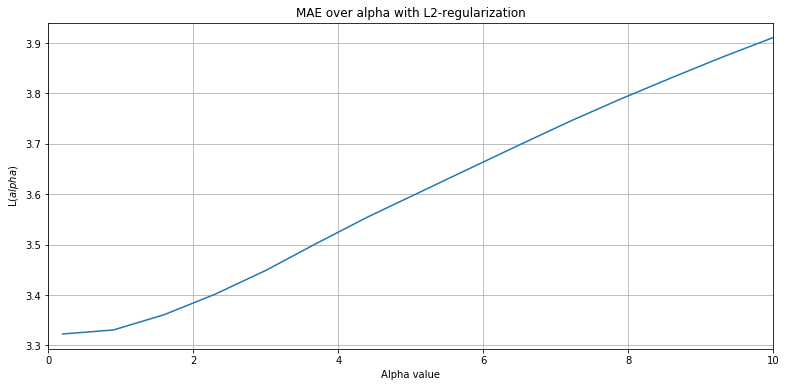

My MAE =  3.2427822379
My RMSE =  5.144387229162173
SkLearn MAE =  3.16379594218
SkLearn RMSE =  4.908971079154384
Difference between mine and Ridge MAE 0.0789862957185
Difference between mine and Ridge RMSE 0.23541615000778915


In [6]:
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
alp = list()
listmae = list()
for a in np.arange(0.2, 10, 0.7):
    alp.append(a)
    listmae.append(optimalalphaL2(x, y, alpha = a))
alphaL2 = alp[listmae.index(min(listmae))]
print('Optimal alpha (L2) : ', alphaL2)
plt.figure(figsize=(13, 6))
plt.plot(alp, listmae)
plt.title('MAE over alpha with L2-regularization')
plt.xlim((0, 10))
plt.xlabel('Alpha value')
plt.ylabel(r'L($alpha$)')
plt.grid()
plt.show()
MyRegL2 = RegL2(4e-4, 1000, 1e-6, alphaL2)
MyRegL2.fit(X_train, y_train)
SkRegL2 = Ridge(alpha = MyRegL2.alpha)
SkRegL2.fit(X_train, y_train)
print('My MAE = ', mean_absolute_error(y_test, MyRegL2.predict(X_test)))
print('My RMSE = ', math.sqrt(mean_squared_error(y_test, MyRegL2.predict(X_test))))
print('SkLearn MAE = ', mean_absolute_error(y_test, SkRegL2.predict(X_test)))
print('SkLearn RMSE = ', math.sqrt(mean_squared_error(y_test, SkRegL2.predict(X_test))))
print('Difference between mine and Ridge MAE', mean_absolute_error(y_test, MyRegL2.predict(X_test)) - mean_absolute_error(y_test, SkRegL2.predict(X_test)))
print('Difference between mine and Ridge RMSE', math.sqrt(mean_squared_error(y_test, MyRegL2.predict(X_test))) - math.sqrt(mean_squared_error(y_test, SkRegL2.predict(X_test))))

### 4 (Бонус, 4 балла). 
* Реализуйте обучение линейной регрессии с L1-регуляризацией (класс RegL1)
* Проведите сравнения аналогично пункту 3 (но с Lasso вместо Ridge).

In [7]:
class RegL1():
    def __init__(self, step_size=1e-4, num_steps=1000, eps=1e-6, alpha = 1):
        self.w = None # веса
        self.step_size = step_size
        self.num_steps = num_steps
        self.eps = eps
        self.alpha = alpha
    
    def __calc_grad(self, X_train, y_train):
        return (2* np.dot(np.transpose(X_train), (np.dot(X_train, self.w) - y_train)) + self.alpha * np.sign(self.w))
    
    def fit(self, X_train, y_train):
        self.w = np.zeros(X_train.shape[1])
        w_current = self.w
        for step in range(self.num_steps):
            w_current = self.w - self.step_size * (self.__calc_grad(X_train, y_train))
            if np.linalg.norm(w_current - self.w, ord = 1) < self.eps:
                break
            self.w = w_current
        return self
        
    def predict(self, X_test):
        return np.dot(X_test, self.w)

In [8]:
def optimalalphaL1(x, y, alpha):
    mae = list()
    Regr = RegL1(2e-4, 1000, 1e-6, alpha)
    mae.append(crossval(Regr, x, y, 5))
    return mae

Optimal alpha (L1) :  0.1


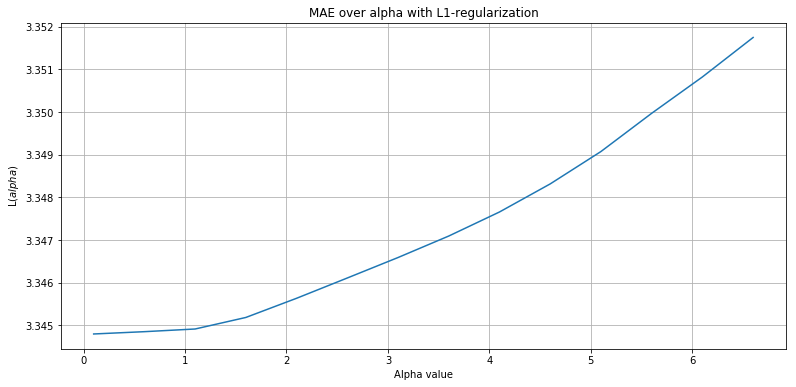

My MAE =  3.26780437468
My RMSE =  5.273885399085883
SkLearn MAE =  3.23172599643
SkLearn RMSE =  5.14174825410229
Difference between mine and Lasso MAE 0.0360783782533
Difference between mine and Lasso RMSE 0.1321371449835933


In [9]:
from sklearn.linear_model import Lasso
alp = list()
listmae = list()
for a in np.arange(0.1, 7, 0.5):
    alp.append(a)
    listmae.append(optimalalphaL1(x, y, a))
alphaL1 = alp[listmae.index(min(listmae))]
print('Optimal alpha (L1) : ', alphaL1)
plt.figure(figsize=(13, 6))
plt.plot(alp, listmae)
plt.title('MAE over alpha with L1-regularization')
plt.xlabel('Alpha value')
plt.ylabel(r'L($alpha$)')
plt.grid()
plt.show()
MyRegL1 = RegL1(2e-4, 1000, 1e-6, alphaL1)
MyRegL1.fit(X_train, y_train)
SkRegL1 = Lasso(alpha = MyRegL1.alpha)
SkRegL1.fit(X_train, y_train)
print('My MAE = ', mean_absolute_error(y_test, MyRegL1.predict(X_test)))
print('My RMSE = ', math.sqrt(mean_squared_error(y_test, MyRegL1.predict(X_test))))
print('SkLearn MAE = ', mean_absolute_error(y_test, SkRegL1.predict(X_test)))
print('SkLearn RMSE = ', math.sqrt(mean_squared_error(y_test, SkRegL1.predict(X_test))))
print('Difference between mine and Lasso MAE', mean_absolute_error(y_test, MyRegL1.predict(X_test)) - mean_absolute_error(y_test, SkRegL1.predict(X_test)))
print('Difference between mine and Lasso RMSE', math.sqrt(mean_squared_error(y_test, MyRegL1.predict(X_test))) - math.sqrt(mean_squared_error(y_test, SkRegL1.predict(X_test))))

### 5 (Бонус, 2 балла). 
Исследуйте для реализации регрессии с L2-регуляризацией зависимость качества на тестовой выборке (с графиками) от:
* Длины шага
* Количества шагов спуска
* Константы epsilon.

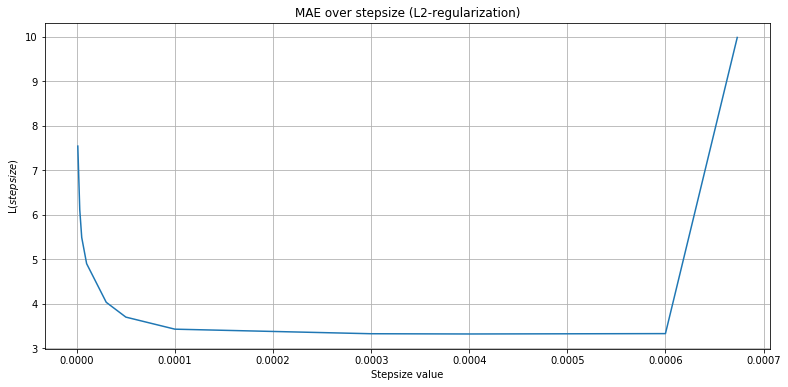

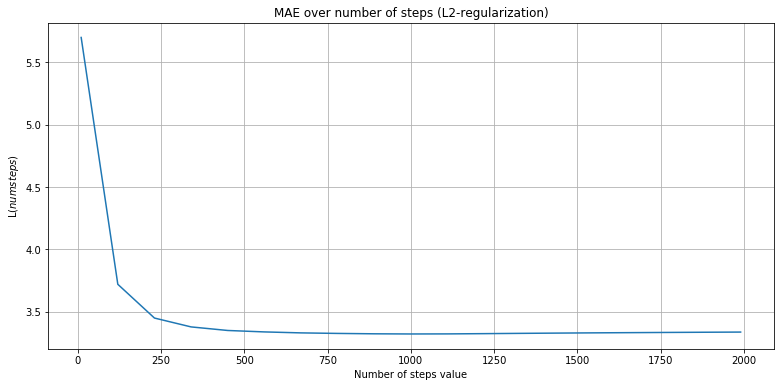

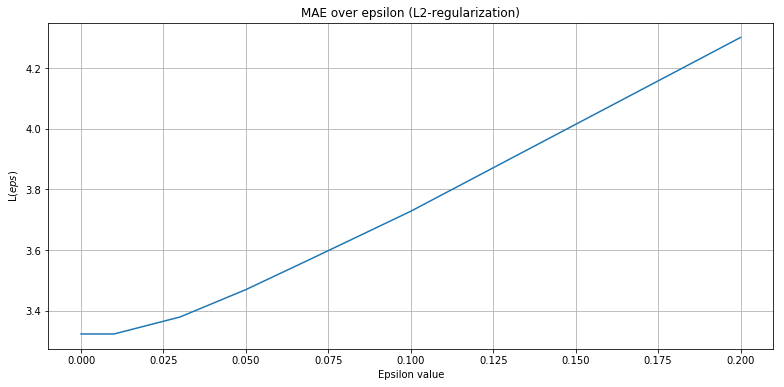

In [10]:
maevalues = list()
stepsizes = [1e-6, 3e-6, 5e-6, 1e-5, 3e-5, 5e-5, 1e-4, 3e-4, 4e-4, 6e-4, 6.732e-4]
numsteps = list()
epsilons = [1e-7, 3e-6, 7e-6, 1e-5, 3e-5, 7e-5, 1e-4, 3e-4, 7e-4, 1e-3, 3e-3, 7e-3, 1e-2 , 3e-2, 5e-2, 7e-2, 1e-1, 2e-1]
for stepsize in stepsizes:
    maevalues.append(optimalalphaL2(x, y, alphaL2, step_size = stepsize))
plt.figure(figsize=(13, 6))
plt.plot(stepsizes, maevalues)
plt.title('MAE over stepsize (L2-regularization)')
plt.xlabel('Stepsize value')
plt.ylabel(r'L($stepsize$)')
plt.grid()
plt.show()
maevalues.clear()
for numstep in np.arange(10, 2000, 110):
    numsteps.append(numstep)
    maevalues.append(optimalalphaL2(x, y, alphaL2, step_size = 4e-4, num_steps = numstep, epsilon = 1e-6))
plt.figure(figsize=(13, 6))
plt.plot(numsteps, maevalues)
plt.title('MAE over number of steps (L2-regularization)')
plt.xlabel('Number of steps value')
plt.ylabel(r'L($numsteps$)')
plt.grid()
plt.show()
maevalues.clear()
for eps in epsilons:
    maevalues.append(optimalalphaL2(x, y, alphaL2, epsilon = eps))
plt.figure(figsize=(13, 6))
plt.plot(epsilons, maevalues)
plt.title('MAE over epsilon (L2-regularization)')
plt.xlabel('Epsilon value')
plt.ylabel(r'L($eps$)')
plt.grid()
plt.show()
maevalues.clear()

### 6 (Бонус, 0 баллов). 
Вставьте сюда любимую картинку, которая сможет поднять настроение ассистенту и семинаристу

In [11]:
from IPython.display import Image
from IPython.core.display import HTML
Image(url='http://4.bp.blogspot.com/_QZ_9mqCmv6w/TQbMh511kdI/AAAAAAAAAOk/n_M_z0dru68/s1600/1283992473801.jpg')